In [61]:
#Basic data handling libs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

#For ADFuller, ACF, PACF, ARIMA 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Boxcox Transformation to reduce Heteroskedasticity
from scipy.stats import boxcox
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#Model Evaluation
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error

#### Load data

In [223]:
df = pd.read_csv('analysis_data.csv')

In [224]:
df

,ID,Date,Units,Revenue,COGS,Profit,City,Region,Category,Segment,Product_Brand,Month,Year,Day
0,0,2013-07-31,12,19648.44,12309.747660,7338.692340,Austin,Central,Urban,Convenience,Pirum,7,2013,31
1,1,2014-03-12,16,20351.52,13497.128064,6854.391936,Torrance,West,Rural,Productivity,Natura,3,2014,12
2,2,2013-11-29,26,111367.62,91488.499830,19879.120170,Salem,East,Urban,Convenience,Currus,11,2013,29
3,3,2018-08-29,12,36280.44,21967.806420,14312.633580,Lithia Springs,East,Rural,Select,Pirum,8,2018,29
4,4,2013-04-27,14,55557.18,48645.866808,6911.313192,Troup,Central,Urban,Convenience,Natura,4,2013,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976238,976238,2013-08-12,1,1070.37,749.794185,320.575815,Mckeesport,East,Rural,Productivity,Aliqui,8,2013,12
976239,976239,2011-12-04,1,1070.37,749.794185,320.575815,Littleton,Central,Rural,Productivity,Aliqui,12,2011,4
976240,976240,2011-05-29,1,1070.37,749.794185,320.575815,Cumming,East,Rural,Productivity,Aliqui,5,2011,29
976241,976241,2014-04-01,1,1070.37,749.794185,320.575815,Rocheport,Central,Rural,Productivity,Aliqui,4,2014,1


#### Aggregate once more for synchronized timestamps

In [225]:
df = df.groupby('Date').agg({
    'Revenue': 'sum',
    'Units': 'sum',
    'COGS':'sum',
    'City': lambda x: x.mode()[0],
    'Segment': lambda x: x.mode()[0],
    'Category': lambda x: x.mode()[0],
})
df.to_csv('analyse.csv')

In [226]:
df = pd.read_csv('analyse.csv')

In [227]:
df

,Date,Revenue,Units,COGS,City,Segment,Category
0,2010-07-04,1765391.67,252,1.340364e+06,Raleigh,Convenience,Urban
1,2010-07-05,1425986.10,208,1.112580e+06,Dayton,Convenience,Urban
2,2010-07-06,302463.00,33,2.373014e+05,Lees Summit,Convenience,Urban
3,2010-07-07,1047787.65,181,8.425688e+05,Kansas City,Convenience,Urban
4,2010-07-08,771811.74,121,6.028101e+05,Whittier,Convenience,Urban
...,...,...,...,...,...,...,...
4248,2022-06-27,1625947.47,217,1.434694e+06,Topmost,Moderation,Urban
4249,2022-06-28,2042916.75,263,1.763163e+06,San Diego,Moderation,Urban
4250,2022-06-29,2284500.33,282,1.971644e+06,Dalton,Moderation,Urban
4251,2022-06-30,700389.90,67,6.056699e+05,Steamboat Springs,Moderation,Urban


#### Encode Target variable and create Time Hierarchy

In [218]:
code = LabelEncoder()

df['City'] = code.fit_transform(df['City'])
df['Segment'] = code.fit_transform(df['Segment'])
df['Category'] = code.fit_transform(df['Category'])

df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

In [219]:
df

,Revenue,Units,COGS,City,Segment,Category,Date,Year,Month,Quarter
Date,,,,,,,,,,
2010-07-04,1765391.67,252,1.340364e+06,974,1,2,2010-07-04,2010,7,3
2010-07-05,1425986.10,208,1.112580e+06,494,1,2,2010-07-05,2010,7,3
2010-07-06,302463.00,33,2.373014e+05,779,1,2,2010-07-06,2010,7,3
2010-07-07,1047787.65,181,8.425688e+05,727,1,2,2010-07-07,2010,7,3
2010-07-08,771811.74,121,6.028101e+05,1118,1,2,2010-07-08,2010,7,3
...,...,...,...,...,...,...,...,...,...,...
2022-06-27,1625947.47,217,1.434694e+06,1080,3,2,2022-06-27,2022,6,2
2022-06-28,2042916.75,263,1.763163e+06,1015,3,2,2022-06-28,2022,6,2
2022-06-29,2284500.33,282,1.971644e+06,488,3,2,2022-06-29,2022,6,2


#### Test for multicollinearity

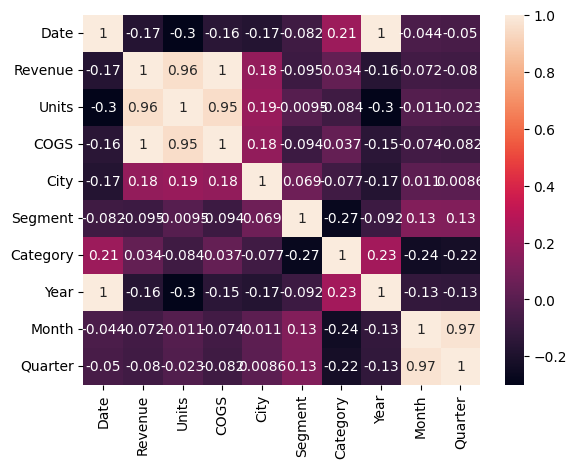

In [8]:
sns.heatmap(df.corr(), annot = True)
plt.show()

#### Drop columns with high multicollinearity

In [12]:
df = df.drop(['Month', 'Year', 'Quarter', 'Units', 'COGS'],axis = 1)


#### Split train and test set

In [14]:
train = df[df['Date'].dt.year <= 2020]
test = df[df['Date'].dt.year > 2020]
print(f'train: {train.shape}\ntest: {test.shape}')

train: (3718, 5)
test: (535, 5)


#### Check for Seasonal pattern

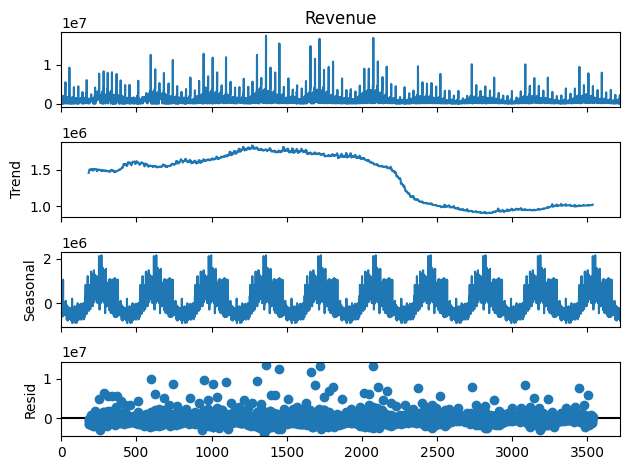

In [15]:
decomposed = seasonal_decompose(train['Revenue'], model='additive', period=365) 
decomposed.plot()
plt.show()

## Use Tests to find the optimal parameters

#### Find parameter d

In [16]:
def find_d(dataset): 
    i = 0
    temp = dataset
    while True:
        result = adfuller(temp['Revenue'].dropna())
        if result[1] < 0.05:
            print(f"Number of difference: {i}")
            print('ADF Statistic: %f' % result[0])
            print('p-value: %f' % result[1])
            break
        else:
            temp = temp.diff().dropna()
            i = i+1
            
            if temp["Revenue"].isna().all():  # Prevent infinite loop
                print("All values became NaN after differencing. Check data.")
                break

In [17]:
find_d(train)

Number of difference: 1
ADF Statistic: -29.458019
p-value: 0.000000


#### Find parameter p and q

In [18]:
def findpq(i, dataset):
  if i == 1:
    X_traindiff = dataset.diff().dropna().dropna()
  if i == 2:
    X_traindiff = dataset.diff().dropna().diff().dropna().dropna()

  fig, axes = plt.subplots(1, 2, figsize=(14, 5))
  
  # ACF plot (for q selection)
  plot_acf(X_traindiff, lags = 15, ax=axes[0])
  axes[0].set_title("Autocorrelation Function (ACF)")

  # PACF plot (for p selection)
  plot_pacf(X_traindiff,lags = 15, ax=axes[1])
  axes[1].set_title("Partial Autocorrelation Function (PACF)")

  plt.show()

#### Set Date to index

In [221]:
train.set_index('Date', inplace = True)
test.set_index('Date', inplace = True)

KeyError: "None of ['Date'] are in the columns"

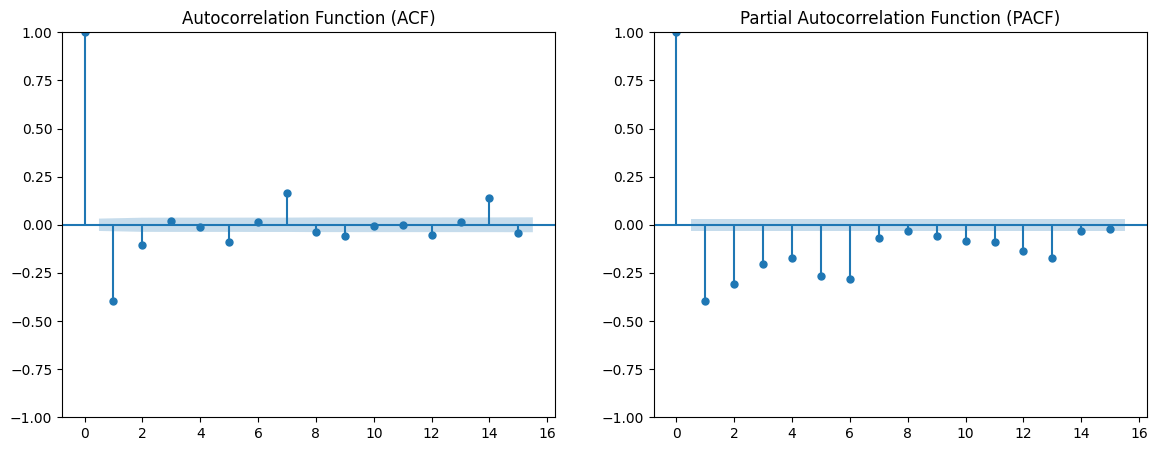

In [25]:
findpq(1, train['Revenue'])

#### Use auto_arima to enhance the guessing

In [26]:
def detect(dataset):
    auto_model = auto_arima(dataset["Revenue"], seasonal=False, trace=True)
    print(auto_model.summary())

In [27]:
detect(train)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=114953.389, Time=8.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=117002.295, Time=0.14 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=116378.562, Time=0.20 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=115179.482, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=117000.296, Time=0.10 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=115044.124, Time=2.68 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=115106.354, Time=1.60 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=115030.338, Time=2.23 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=115035.108, Time=6.23 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=115121.616, Time=1.16 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=114974.325, Time=7.78 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=115104.042, Time=2.60 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=114986.401, Time=16.60 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=114951.362, Time=6.76 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=115042.115, Time=2.77 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=115104.364, Time=2.23 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=115028.334, Time=2.66 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=115033.117, Time=5.36 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=115119.629, Time=1.22 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=114961.816, Time=4.77 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=115102.052, Time=1.96 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=114984.402, Time=16.57 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 94.542 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3718
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -57470.681
Date:                Sun, 23 Feb 2025   AIC                         114951.362
Time:                        11:15:54   BIC                         114982.466
Sample:                             0   HQIC                        114962.429
                               - 3718                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0859      0.013     84.749      0.000       1.

#### Use another auto_arima to find the parameter for seasonality (SARIMA)

In [30]:
def detect_parameter(train_data, p, d, q):
    auto_arima(train_data['Revenue'], seasonal=True, 
        p=p, d=d, q=q,  # We already know p,d,q
        P=None, D=None, Q=None,  # Let auto_arima find seasonal orders
        m=7,  # to work with weekly trend
        trace=True)

In [31]:
detect_parameter(train, 2,1,2)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=114833.064, Time=7.02 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=117002.295, Time=0.12 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=116212.417, Time=0.98 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=115115.602, Time=2.02 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=117000.296, Time=0.09 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=114870.817, Time=21.26 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=114944.797, Time=4.39 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=114826.761, Time=31.60 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=114882.642, Time=6.58 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=114821.171, Time=26.84 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=114826.117, Time=22.65 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,2)[7] intercept   : AIC=114840.314, Time=20.59 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,2)[7] intercept   : AIC=114931.842, Time=15.63 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(2,0,2)[7] intercept   : AIC=114823.795, Time=18.24 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(2,0,2)[7] intercept   : AIC=114821.789, Time=49.40 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=114936.392, Time=14.43 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(2,0,2)[7] intercept   : AIC=114836.500, Time=24.66 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,2)[7] intercept   : AIC=114933.596, Time=13.41 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(2,0,2)[7] intercept   : AIC=114823.571, Time=24.19 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,2)[7]             : AIC=114819.166, Time=16.83 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,2)[7]             : AIC=114824.096, Time=12.26 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[7]             : AIC=114824.741, Time=12.96 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,1)[7]             : AIC=114831.047, Time=3.95 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,2)[7]             : AIC=114838.291, Time=12.83 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,2)[7]             : AIC=114929.857, Time=7.37 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(2,0,2)[7]             : AIC=114821.786, Time=7.82 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(2,0,2)[7]             : AIC=114819.246, Time=21.51 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,2)[7]             : AIC=114934.407, Time=6.57 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(2,0,2)[7]             : AIC=114833.298, Time=14.55 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,2)[7]             : AIC=114931.611, Time=11.10 sec


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(2,0,2)[7]             : AIC=114821.203, Time=23.61 sec

Best model:  ARIMA(2,1,2)(2,0,2)[7]          
Total fit time: 455.545 seconds


## Run the ARIMA, SARIMA and SARIMAX tests

#### Scale the Revenue for less RMSE and higher Accuracy


In [ ]:
scaler = StandardScaler()
train[['Revenue']] = scaler.fit_transform(train[['Revenue']])
test[['Revenue']] = scaler.transform(test[['Revenue']])

train[['City']] = scaler.fit_transform(train[['City']])
test[['City']] = scaler.transform(test[['City']])

### ARIMA Model

In [201]:
def arima(p,d,q, dataset, test_data):
  
  model = ARIMA(dataset['Revenue'], order=(p,d,q))  
  model_fit = model.fit()
  print(model_fit.summary())
    
  start = 3031
  pred = model_fit.predict(start = start, end= start + len(test_data) - 1, typ = 'levels')
    
  residuals = test_data['Revenue'] - pred
  
  rmse = root_mean_squared_error(test_data['Revenue'], pred)
  mape = mean_absolute_percentage_error(test_data['Revenue'], pred)
  r2 = r2_score(test_data['Revenue'], pred)

  print(f"RMSE: {rmse:.2f}")
  print(f"MAPE: {mape * 100:.2f}%")
  print(f"R²: {r2:.4f}")

In [202]:
arima(2,1,2, train, test)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                 3718
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4954.417
Date:                Sun, 23 Feb 2025   AIC                           9918.835
Time:                        13:49:53   BIC                           9949.938
Sample:                             0   HQIC                          9929.901
                               - 3718                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0860      0.012     90.209      0.000       1.062       1.110
ar.L2         -0.1894      0.013    -14.112      0.000      -0.216      -0.163
ma.L1         -1.9325      0.008   -227.921      0.0

### SARIMA Model

In [130]:
def sarima(p, d, q, P, D, Q, s, train_data, test_data):
    
    # Fit SARIMAX model
    model = SARIMAX(train_data['Revenue'], 
                    order=(p, d, q), 
                    seasonal_order=(P, D, Q, s), mle_regression = False)
    model_fit = model.fit(disp=False)

    # Forecast for the length of test data
    start = 3031
    pred = model_fit.predict(start = start, end= start + 534, typ = 'levels')
        

    
    print(model_fit.summary())
    
    # Calculate evaluation metrics
    rmse = root_mean_squared_error(test_data['Revenue'], pred)
    mape = mean_absolute_percentage_error(test_data['Revenue'], pred)
    r2 = r2_score(test_data['Revenue'], pred)

    # Display metrics
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape * 100:.2f}%")
    print(f"R²: {r2:.4f}")
    
    # Plot predictions vs actual values
    plt.figure(figsize=(10, 5))
    plt.plot(train_data.index, train_data['Revenue'], label='Train Data')
    plt.plot(test_data.index, test_data['Revenue'], label='Actual Test Data')
    plt.plot(test_data.index, pred, label='Forecast', linestyle='--')
    plt.legend()
    plt.title('SARIMAX Forecast vs Actual')
    plt.show()
    
    return model_fit

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-st

                                     SARIMAX Results                                     
Dep. Variable:                           Revenue   No. Observations:                 3718
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood               -4876.572
Date:                           Sun, 23 Feb 2025   AIC                           9771.145
Time:                                   12:57:35   BIC                           9827.131
Sample:                                        0   HQIC                          9791.064
                                          - 3718                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1418      0.331     -0.428      0.669      -0.791       0.507
ar.L2         -0.0059      0.049     -0.121

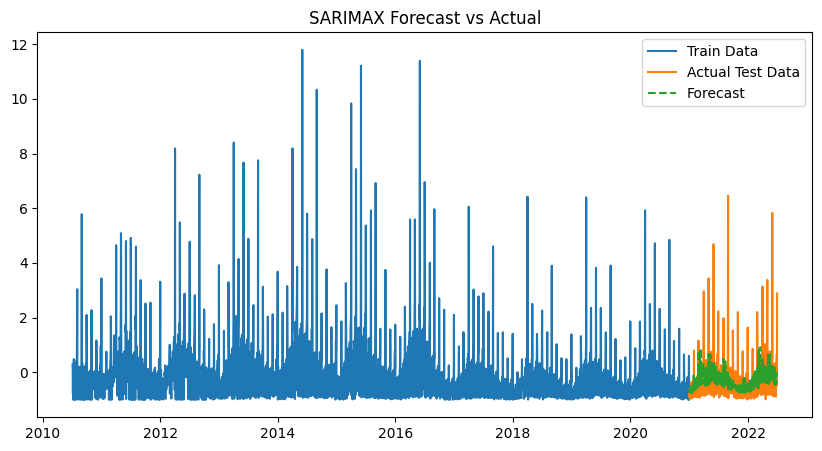

In [131]:
sarima(2,1,2,2,0,2,7, train, test)

### SARIMAX Model

In [142]:
def sarimax(p, d, q, P, D, Q, s, train_data, test_data):
    
    # Fit SARIMAX model
    model = SARIMAX(train_data['Revenue'], 
                    exog = train_data[['Category','Segment']],
                    order=(p, d, q), 
                    seasonal_order=(P, D, Q, s), mle_regression = False)
                    
    model_fit = model.fit(disp=False)
    
    # Forecast for the length of test data
    start = 3031
    pred = model_fit.predict(start = start, end= start + len(test_data) - 1, typ = 'levels',exog = test_data[['Category','Segment']])
    
    
    # Ensure prediction and test data are aligned
    pred = pred[:len(test_data)]
    
    print(model_fit.summary())
    
    # Calculate evaluation metrics
    rmse = root_mean_squared_error(test_data['Revenue'], pred)
    mape = mean_absolute_percentage_error(test_data['Revenue'], pred)
    r2 = r2_score(test_data['Revenue'], pred)

    # Display metrics
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape * 100:.2f}%")
    print(f"R²: {r2:.4f}")
    
    # Plot predictions vs actual values
    plt.figure(figsize=(10, 5))
    plt.plot(train_data.index, train_data['Revenue'], label='Train Data')
    plt.plot(test_data.index, test_data['Revenue'], label='Actual Test Data')
    plt.plot(test_data.index, pred, label='Forecast', linestyle='--')
    plt.legend()
    plt.title('SARIMAX Forecast vs Actual')
    plt.show()
    
    return model_fit

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-st

                                     SARIMAX Results                                     
Dep. Variable:                           Revenue   No. Observations:                 3718
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood               -4892.231
Date:                           Sun, 23 Feb 2025   AIC                           9802.463
Time:                                   13:04:07   BIC                           9858.444
Sample:                                        0   HQIC                          9822.381
                                          - 3718                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5672      0.371     -1.528      0.127      -1.295       0.160
ar.L2          0.0677      0.057      1.188

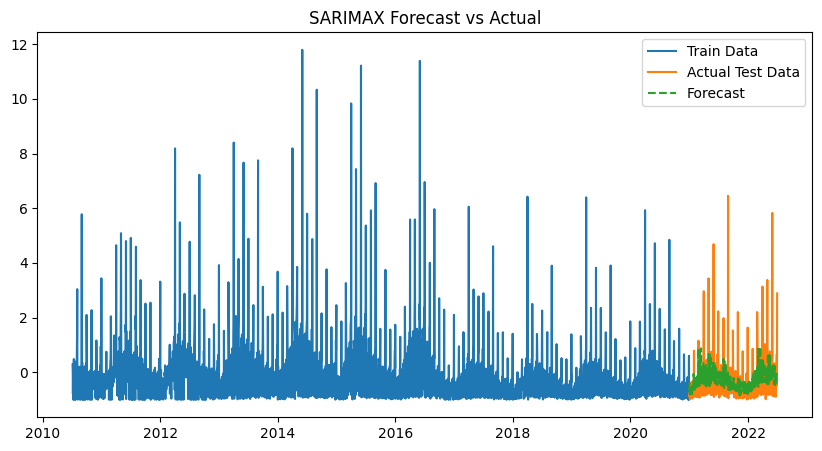

In [143]:
sarimax(2,1,2,2,0,2,7,train, test)

### Run Forecast for 2023 using SARIMA

In [199]:
def sarimax_forecast(p, d, q, P, D, Q, s, train_data, test_data, future_periods=12):
    
    # Fit SARIMAX model
    model = SARIMAX(train_data['Revenue'], 
                    order=(p, d, q), 
                    seasonal_order=(P, D, Q, s), 
                    mle_regression=False)
    model_fit = model.fit(disp=False)
    
    # Forecast for test data
    start = 3031
    pred_test = model_fit.predict(start=start, end=start + len(test_data) - 1, typ='levels')
    
    # Forecast for future periods
    future_index = pd.date_range(start=test_data.index[-1], periods=future_periods + 1, freq='M')[1:]
    pred_future = model_fit.predict(start=start + len(test_data), end=start + len(test_data) + future_periods - 1, typ='levels')
    #pred_future = scaler.inverse_transform([pred_future])
    
    
    # Calculate evaluation metrics on test data
    rmse = root_mean_squared_error(test_data['Revenue'], pred_test)
    mape = mean_absolute_percentage_error(test_data['Revenue'], pred_test)
    r2 = r2_score(test_data['Revenue'], pred_test)
    
    # Display metrics
    print(model_fit.summary())
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape * 100:.2f}%")
    print(f"R²: {r2:.4f}")

    # Plot predictions vs actual values
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data['Revenue'], label='Train Data')
    plt.plot(test_data.index, test_data['Revenue'], label='Actual Test Data')
    plt.plot(test_data.index, pred_test, label='Test Forecast', linestyle='--')
    plt.plot(future_index, pred_future, label='Future Forecast (2023)', linestyle='dotted', color='red')
    plt.legend()
    plt.title('SARIMAX Forecast vs Actual')
    plt.show()
    
    future = scaler.inverse_transform([pred_future])*1000
    f = pd.DataFrame({'Month': np.arange(1,13), 'Predicted Revenue': future.flatten()})
    
    return model_fit, f
    

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-st

                                     SARIMAX Results                                     
Dep. Variable:                           Revenue   No. Observations:                 3718
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood               -4876.563
Date:                           Sun, 23 Feb 2025   AIC                           9771.126
Time:                                   13:34:50   BIC                           9827.112
Sample:                                        0   HQIC                          9791.046
                                          - 3718                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1474      0.333     -0.443      0.658      -0.799       0.504
ar.L2         -0.0047      0.049     -0.096

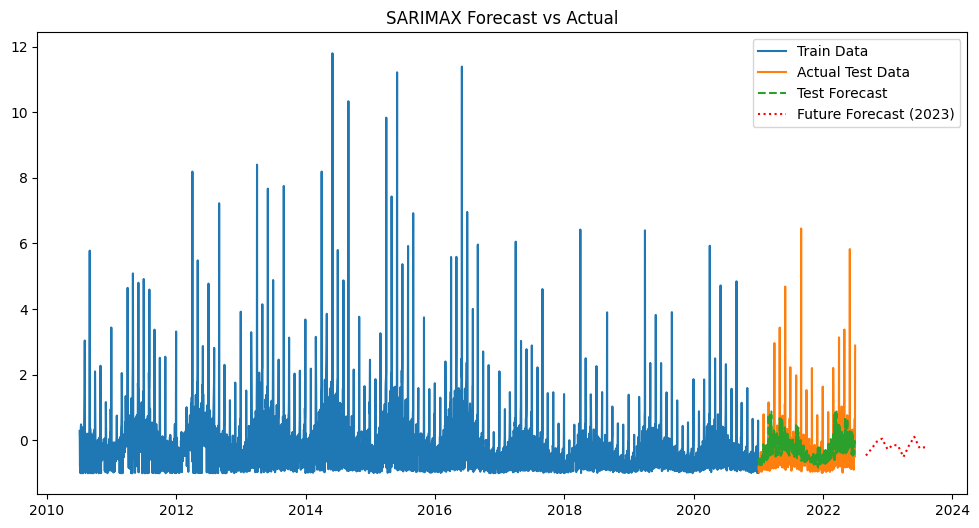

(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1fd01fe5400>,
     Month  Predicted Revenue
 0       1      435641.557910
 1       2      498564.981042
 2       3      572076.255626
 3       4      601715.841162
 4       5      496638.456666
 5       6      540848.192542
 6       7      533724.080097
 7       8      421735.676016
 8       9      530639.008547
 9      10      620318.290729
 10     11      508112.582527
 11     12      518004.285986)

In [200]:
sarimax_forecast(2,1,2,2,0,2,7, train, test, 12)

### Comment
- The ARIMA model is susceptible with large dataset and requires huge Computational Cost to fine-tune the parameters

- The bad Performance Metrics is mainly due to the lack of fine-tuned hyperparameter like m (which can be set to 30-month, 120-season or 365-year) to increase the accuracy

- However, this will act as a base for other more efficient ts models